In [ ]:
from config import HEIGHT, WIDTH

In [1]:
import torch 
print(torch.cuda.device_count())
import sys
sys.path.append('..')

1


In [2]:
# !export CUDA_VISIBLE_DEVICES=1
# !export CUDA_LAUNCH_BLOCKING=1
import os
import torch
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
from diffusers import StableDiffusionPipeline

2024-07-27 16:02:38.107990: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-27 16:02:38.905516: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda


100%|██████████| 16/16 [00:03<00:00,  5.04it/s]


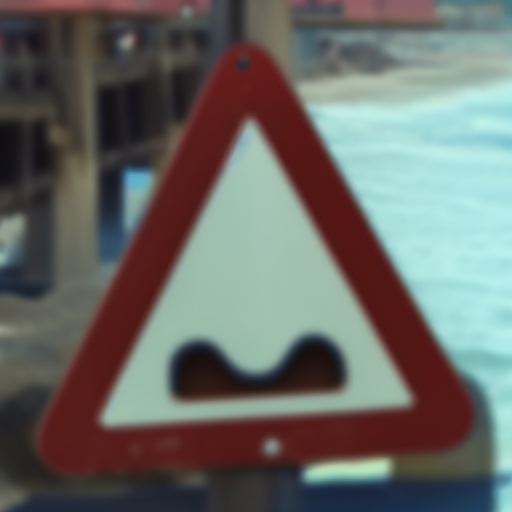

In [22]:
import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch

DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("../../data/vocab.json", merges_file="../../data/merges.txt")
model_file = "../../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

## TEXT TO IMAGE

# prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "A trafic sign on a beautiful beach."
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

# Comment to disable image to image
image_path = "../../images/dog.png"
input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.48

## SAMPLER

sampler = "ddpm"
num_inference_steps = 34
seed = 43

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

In [5]:
num_inference_steps = 6
from finetune import train
train(
    dataset_path="../../../Sample",
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cuda",
    tokenizer=tokenizer,
    epochs=13,
    batch_size=2,
    lr=1e-4,
    size=(WIDTH, HEIGHT),
)


Number of images: 15
Shape of the first image: (141, 142, 3)
Number of batches: 15
Shape of the first batch: torch.Size([3, 512, 512])


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


Epoch [1/13], Loss: 0.0051


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


Epoch [2/13], Loss: 0.0020


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


Epoch [3/13], Loss: 0.0015


100%|██████████| 15/15 [00:32<00:00,  2.13s/it]


Epoch [4/13], Loss: 0.0010


100%|██████████| 15/15 [00:32<00:00,  2.13s/it]


Epoch [5/13], Loss: 0.0028


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


Epoch [6/13], Loss: 0.0013


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


Epoch [7/13], Loss: 0.0006


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


Epoch [8/13], Loss: 0.0011


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


Epoch [9/13], Loss: 0.0006


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


Epoch [10/13], Loss: 0.0004


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


Epoch [11/13], Loss: 0.0004


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


Epoch [12/13], Loss: 0.0005


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


Epoch [13/13], Loss: 0.0006
Models saved to ../../data/finetuned_models.ckpt


100%|██████████| 16/16 [00:03<00:00,  5.00it/s]


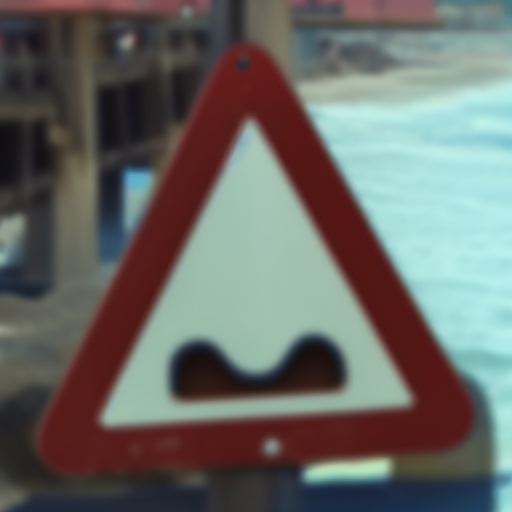

In [26]:
# path = "../data/v1-5-pruned-emaonly.ckpt"
# checkpoint = torch.load(path, map_location=DEVICE)
# model = torch.load(path)
num_inference_steps = 50
model_file = "../../data/finetuned_models.ckpt"
model = torch.load(model_file, map_location=DEVICE)

prompt = "A trafic sign on a beautiful beach."
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

# Comment to disable image to image
image_path = "../../images/dog.png"
input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.48

## SAMPLER

sampler = "ddpm"
num_inference_steps = 34
seed = 43

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)


100%|██████████| 16/16 [00:03<00:00,  4.90it/s]


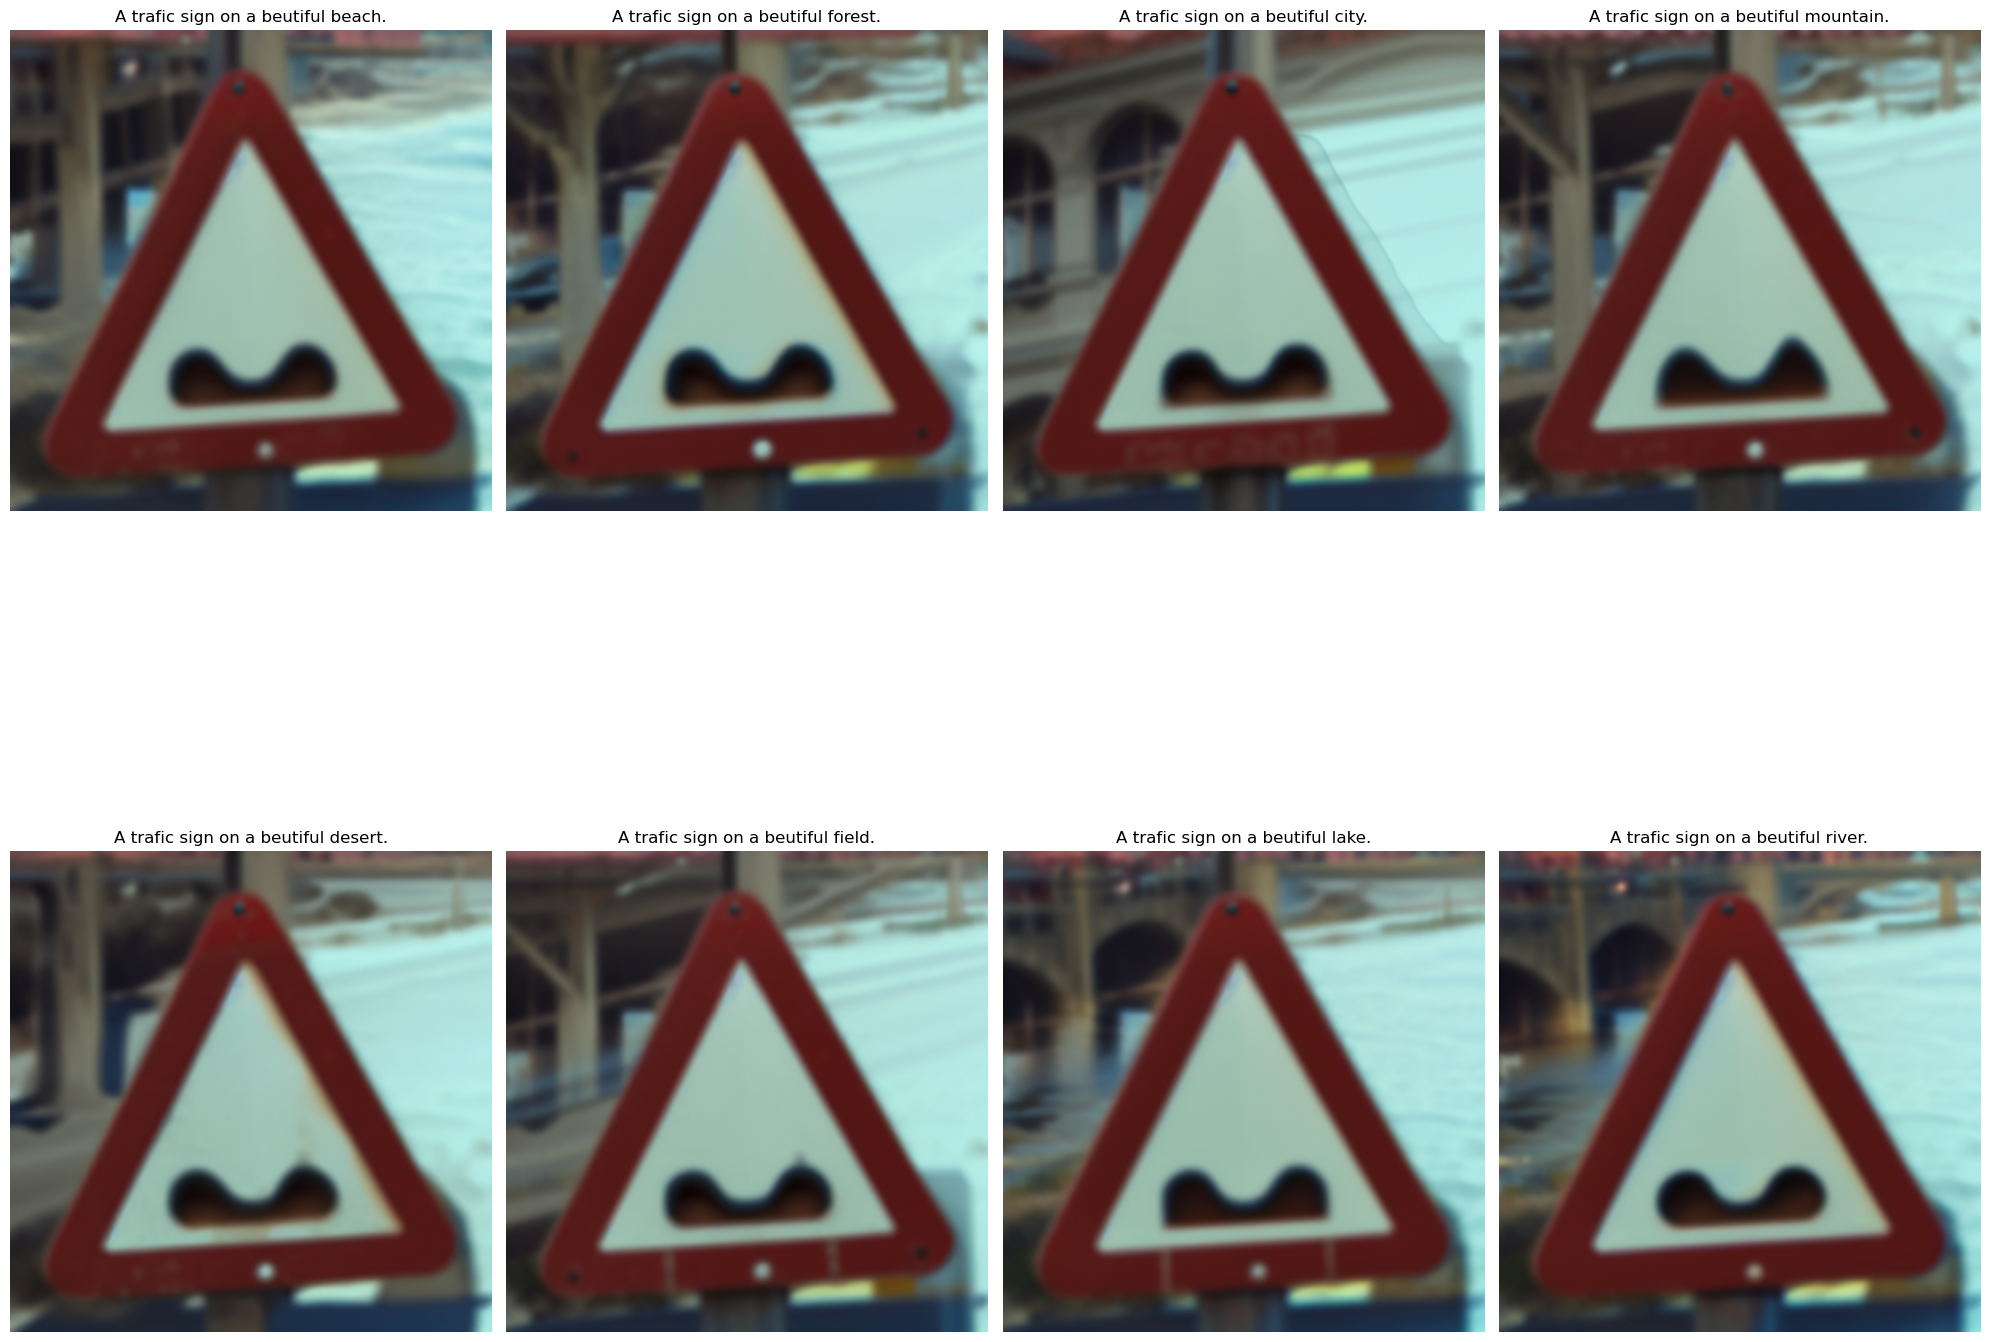

In [27]:
objs = ["beach", "forest", "city", "mountain", "desert", "field", "lake", "river"]
prompt = f"A trafic sign on a beutiful {objs}."

import matplotlib.pyplot as plt
import numpy as np
#  subplots
def plot_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Generate images for each object
images = []
titles = []

import time
for obj in objs:
    start = time.time()
    prompt = f"A trafic sign on a beutiful {obj}."
    output_image = pipeline.generate(
        prompt=prompt,
        uncond_prompt=uncond_prompt,
        input_image=input_image,
        strength=strength,
        do_cfg=do_cfg,
        cfg_scale=cfg_scale,
        sampler_name=sampler,
        n_inference_steps=num_inference_steps,
        seed=seed,
        models=models,
        device=DEVICE,
        idle_device="cpu",
        tokenizer=tokenizer,
    )
    images.append(output_image)
    titles.append(prompt)
    end = time.time()
    print(f"Generated image for {obj} in {end-start:.2f} seconds.")

plot_images(images, titles, 2, 4)


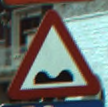

: 

In [28]:
Orginal_image = Image.open("../../images/dog.png")
Orginal_image


In [ ]:
from PIL import Image
import numpy as np
def PIL2torch(image):
    # if np.array(image).shape[0] == 512:
    #     return torch.tensor(np.array(image), dtype=torch.uint8).permute(2, 0, 1)
    # else:
    #     # scale image to 512x512
        # image = image.resize((512, 512))
        return torch.tensor(np.array(image), dtype=torch.uint8).permute(2, 0, 1)
from torchmetrics import FID
imgs_dist1 = PIL2torch(input_image).unsqueeze(0)  # doctest: +SKIP
imgs_dist2 = PIL2torch(output_image).unsqueeze(0)  # doctest: +SKIP
imgs_dist1 = torch.cat([imgs_dist1, imgs_dist1], dim=0)
imgs_dist2 = torch.cat([imgs_dist2, imgs_dist2], dim=0)

# print dtype
imgs_dist1.shape, imgs_dist2.shape

In [ ]:
import torch
_ = torch.manual_seed(123)
fid = FID(feature=64)  # doctest: +SKIP
fid.update(imgs_dist1, real=True)  # doctest: +SKIP
fid.update(imgs_dist2, real=False)  # doctest: +SKIP
fid.compute()  # doctest: +SKIP